<a href="https://colab.research.google.com/github/sakshivedi-1/Fashion_MNIST_neural_net/blob/main/Fashion_mnist_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation and Import**

In [1]:
!pip install wandb -q
import wandb
wandb.login()

import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vedisakshi2808 (vedisakshi2808-indian-institute-of-information-technolog) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Load Data**



In [18]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



# **Plot sample image for each class**

Sample Images


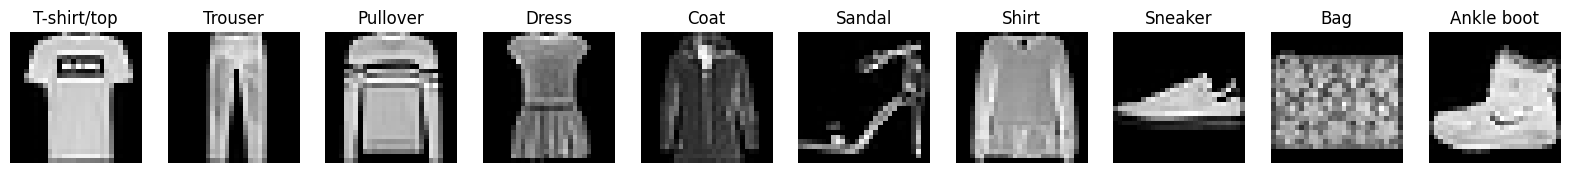

In [17]:
def plot_sample(x, y, classes):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    unique_classes = np.unique(y)
    for i, cls in enumerate(unique_classes):
        idx = np.where(y ==cls)[0][0]
        img = x[idx]

        axes[i].imshow(img,cmap='gray')
        axes[i].set_title(classes[cls])
        axes[i].axis('off') # Hide axes

    plt.show()

print("Sample Images")
plot_sample(x_train, y_train, class_names)